In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from utils import *
from ipywidgets import interact, widgets
np.set_printoptions(precision=3)

# 1. Visualizing MLE and MAP

### Let's generate some data from a linear model

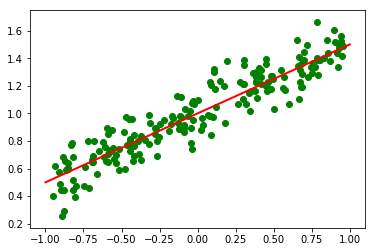

In [2]:
np.random.seed(3)
# Equation is 
# y = 0.5 x + 1.0
coeffs = [1, 0.5]
x, y = polynomial_data(coeffs, n_data=200)
plot_polynomial(coeffs)
plt.scatter(x, y, color='green')

### Now we'll write a function to compute -log p(data = D | model = f_theta)

In [3]:
def mse(x, y, coeffs):
    return np.mean((x.dot(coeffs.T) - y)**2, axis=0)

def pdata_mle(x, y, coeffs, sigma_2):
    error = mse(x, y, coeffs)
    return error / (2 * sigma_2)

def pdata_map(x, y, coeffs, sigma_2, prior_mu, prior_sigma_2):
    error_est = mse(x, y, coeffs)
    error_prior = np.sum((np.array(coeffs) - prior_mu) ** 2, axis=1)
    return error_est / (2 * sigma_2) + error_prior / (2 * prior_sigma_2)

### How does this function look for different choices of coefficients?

In [4]:
def plot_loss_contours_mle(x, y, sigma=1.0, gt_coeffs=[0, 0], x0_range=(-2, 2), x1_range=(-2, 2)):
    x0 = np.linspace(*x0_range, 100)
    x1 = np.linspace(*x1_range, 100)
    X0, X1 = np.meshgrid(x0, x1)
    inputs = np.column_stack([X0.flatten(), X1.flatten()])
    outputs = pdata_mle(polynomial_features(x, 1), y, inputs, sigma)
    outputs = outputs.reshape(X0.shape)
    min_val_at = np.unravel_index(outputs.argmin(), outputs.shape)
    min_x0 = x0[min_val_at[0]]
    min_x1 = x1[min_val_at[1]]
    
    fig, ax = plt.subplots(figsize=(5, 4))
    plt.contourf(X0, X1, outputs, cmap=plt.cm.Blues)
    plt.colorbar()
    plt.scatter([gt_coeffs[0]], [gt_coeffs[1]], marker='x', color='r', label='Ground truth parameters')
    plt.scatter([min_x1], [min_x0], marker='o', color='g', label='MLE parameters')
    plt.title("MLE parameter estimates for f(x) = w0 + w1 * x")
    plt.xlabel("w0")
    plt.ylabel("w1")
    plt.legend()
    
interactive_plot = lambda sigma: plot_loss_contours_mle(x, y, sigma=sigma, gt_coeffs=coeffs)
interact(interactive_plot, sigma=(0.1, 1.0, 0.1))

interactive(children=(FloatSlider(value=0.5, description='sigma', max=1.0, min=0.1), Output()), _dom_classes=(…

<function __main__.<lambda>(sigma)>

### MAP estimate

In [5]:
def plot_loss_contours_map(x, y, prior_mean=(0, 0), prior_sigma=0.1, sigma=1.0, gt_coeffs=[0, 0], x0_range=(-2, 2), x1_range=(-2, 2)):
    x0 = np.linspace(*x0_range, 100)
    x1 = np.linspace(*x1_range, 100)
    X0, X1 = np.meshgrid(x0, x1)
    inputs = np.column_stack([X0.flatten(), X1.flatten()])
    outputs = pdata_map(polynomial_features(x, 1), y, inputs, sigma, prior_mean, prior_sigma)
    outputs = outputs.reshape(X0.shape)
    min_val_at = np.unravel_index(outputs.argmin(), outputs.shape)
    min_x0 = x0[min_val_at[0]]
    min_x1 = x1[min_val_at[1]]
    
    fig, ax = plt.subplots(figsize=(5, 4))
    plt.contourf(X0, X1, outputs, cmap=plt.cm.Blues)
    plt.colorbar()
    plt.scatter([gt_coeffs[0]], [gt_coeffs[1]], marker='x', color='r', label='Ground truth parameters')
    plt.scatter([min_x1], [min_x0], marker='o', color='g', label='MAP parameters')
    plt.scatter([prior_mean[0]], [prior_mean[1]], marker='x', color='black', label='Prior parameter mean')
    plt.legend()

In [6]:
interactive_plot = lambda prior_mean_x0, prior_mean_x1, prior_sigma: plot_loss_contours_map(x, y, prior_mean=[prior_mean_x0, prior_mean_x1], prior_sigma=prior_sigma, sigma=1.0, gt_coeffs=coeffs)
interact(interactive_plot, prior_mean_x0=(-1.0, 1.0, 0.1), prior_mean_x1=(-1.0, 1.0, 0.1), prior_sigma=(0.1, 50.1, 1))

interactive(children=(FloatSlider(value=0.0, description='prior_mean_x0', max=1.0, min=-1.0), FloatSlider(valu…

<function __main__.<lambda>(prior_mean_x0, prior_mean_x1, prior_sigma)>

# 2. Bias-variance tradeoff

### Recall:

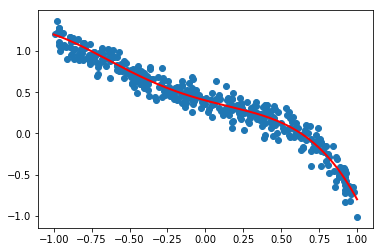

In [7]:
np.random.seed(0)
coeffs = [0.4, -0.5, 0.3, -0.5, -0.5]
DATASET_SIZE = 400
x, y = polynomial_data(coeffs, n_data=DATASET_SIZE)
plt.scatter(x, y)
plot_polynomial(coeffs)

### How to choose degree of polynomial? Validation sets

In [8]:
N_TRAIN = DATASET_SIZE // 2
x_train, y_train = x[:N_TRAIN], y[:N_TRAIN]
x_val, y_val = x[N_TRAIN:], y[N_TRAIN:]

errs_train = []
ws_train = []
errs_val = []
for i in range(20):
    w, err = least_squares(polynomial_features(x_train, i), y_train)
    errs_train.append(err)
    errs_val.append(validation_error(x_val, y_val, w))
    ws_train.append(w)

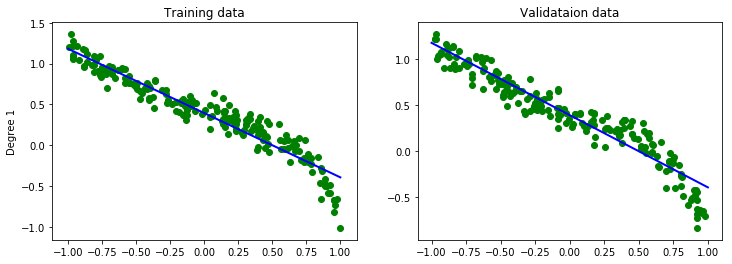

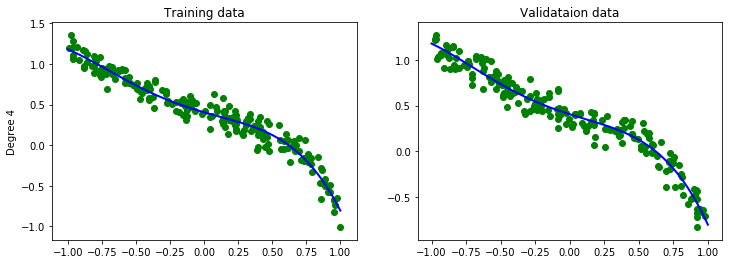

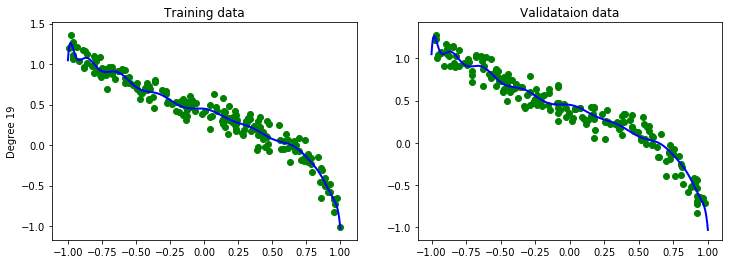

In [9]:
plot_poly_on_train_val(x_train, y_train, x_val, y_val, ws_train[1], "Degree 1")
plot_poly_on_train_val(x_train, y_train, x_val, y_val, ws_train[4], "Degree 4")
plot_poly_on_train_val(x_train, y_train, x_val, y_val, ws_train[19], "Degree 19")

# Can we make this more concrete?

### Let's generate a bunch of datasets of different sizes

In [10]:
x_datasets = {}
y_datasets = {}
dataset_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
n_datasets_per_size = 20

for dsize in dataset_sizes:
    x_datasets[dsize] = []
    y_datasets[dsize] = []
    for i in range(n_datasets_per_size):
        x_, y_ = polynomial_data(coeffs, n_data=dsize)
        x_datasets[dsize].append(x_)
        y_datasets[dsize].append(y_)

### Now we'll fit regressions to each dataset

In [11]:
feature_sizes = np.arange(1, 11)
regression_coeffs = {}
regression_errs = {}
ridge_lambda = [0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]

for fsize in feature_sizes:
    regression_coeffs[fsize] = {}
    regression_errs[fsize] = {}
    for lam in ridge_lambda:
        regression_coeffs[fsize][lam] = {}
        regression_errs[fsize][lam] = {}
        for dsize in dataset_sizes:
            regression_coeffs[fsize][lam][dsize] = []
            regression_errs[fsize][lam][dsize] = []
            for x_, y_ in zip(x_datasets[dsize], y_datasets[dsize]):
                features = polynomial_features(x_, fsize)
                w, err = ridge_regression(features, y_, l=lam)
                regression_coeffs[fsize][lam][dsize].append(w)
                regression_errs[fsize][lam][dsize].append(err)
                

In [12]:
def plot_regression_fits(feature_size, ridge_lambda, dset_size, dset_idx):
    x_, y_ = x_datasets[dset_size][dset_idx], y_datasets[dset_size][dset_idx]
    rcoeffs = regression_coeffs[feature_size][ridge_lambda][dset_size]
    all_x_vals = np.linspace(-1, 1, 101)
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.title("Regression fits")
    plt.xlim(-1.0, 1.0)
    plt.ylim(-1.0, 1.5)
    for rcoef in rcoeffs[:-1]:
        plot_polynomial(rcoef, color='orange', alpha=0.2, label=None)
    plot_polynomial(rcoeffs[-1], color='orange', alpha=0.2, label='other models')
    plot_polynomial(rcoeffs[dset_idx], label='this model')
    plt.legend()
    plt.scatter(x_, y_)
    
    err = regression_errs[feature_size][ridge_lambda][dset_size][dset_idx]
    plt.subplot(122)
    plt.title("Error")
    plt.xlim(-5, 5)
    plt.ylim(0, 0.15)
    plt.xticks([])
    plt.bar(0, err)
    plt.show()

In [13]:
interactive_plot = lambda prior_mean_x0, prior_mean_x1, prior_sigma: plot_loss_contours_map(x, y, prior_mean=[prior_mean_x0, prior_mean_x1], prior_sigma=prior_sigma, sigma=1.0, gt_coeffs=coeffs)

In [14]:
interactive_plot = lambda f_size, r_lam, dset_size, dset_idx: plot_regression_fits(f_size, (r_lam > 0) * 10 ** (r_lam -5), 10*(dset_size+1), dset_idx)
interact(interactive_plot, r_lam=(0, 6), f_size=(1, 10), dset_size=(0, 9), dset_idx=(0, n_datasets_per_size-1))

interactive(children=(IntSlider(value=5, description='f_size', max=10, min=1), IntSlider(value=3, description=…

<function __main__.<lambda>(f_size, r_lam, dset_size, dset_idx)>